# grn bench perturb seq


In [1]:
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GRNfer

from bengrn import BenGRN, get_perturb_gt

from bengrn.base import train_classifier

from bengrn import compute_genie3, compute_scenic
from grnndata import utils as grnutils

import scanpy as sc

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_types.py:9: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.i

In [2]:
adata = get_perturb_gt()

adata.var["isTF"] = False
adata.var.loc[adata.var.gene_name.isin(grnutils.TF), "isTF"] = True
adata.var["isTF"].sum()
metrics = {}

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/gem_group' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/__categories/gene' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Ele

650

In [3]:
preprocessor = Preprocessor(force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
nadata = preprocessor(adata.copy())
adata

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 10691 renamining
filtered out 0 cells, 10691 renamining
Removed 8 genes.
startin QC
Seeing 10068 outliers (94.17% of total dataset):
done


GRnnData object with n_obs × n_vars = 10691 × 8563
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'organism_ontology_term_id'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'isTF'
    varp: 'GRN'
    with a grn of 1115065 elements

In [4]:
model = scPrint.load_from_checkpoint(
    '../data/temp/o2uniqsx/epoch=18-step=133000.ckpt', precpt_gene_emb=None)
#    '../data/temp/wli32e2j/last.ckpt', precpt_gene_emb=None)
#    '../data/temp/vbd8bavn/epoch=17-step=90000.ckpt', precpt_gene_emb=None)
#    '../data/temp/25eer0xz/epoch=20-step=105000.ckpt', precpt_gene_emb=None)

RuntimeError caught: scPrint is not attached to a `Trainer`.



In [5]:
NUM_GENES = 5000
NUM_CELLS = 1024

In [6]:
grn_inferer = GRNfer(model, nadata[nadata.X.sum(1) > 500],
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     num_genes=NUM_GENES,
                     max_cells=NUM_CELLS,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])

KeyboardInterrupt: 

In [ ]:
grn.varp['all'] = grn.varp["GRN"]

In [ ]:
grn.varp['GRN'] = grn.varp["all"].mean(-1).T
metrics['scprint_mean_perturb'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

In [ ]:
grn.var

In [ ]:
grn.var['ensembl_id'] = grn.var.index
grn.var.index = grn.var['symbol']
metrics['scprint_mean_perturb_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

In [ ]:
grn.varp['GRN'] = grn.varp["all"]
grn.var.index = grn.var['ensembl_id']
grn, m, clf_omni = train_classifier(grn, C=0.1, train_size=0.9, class_weight={
                                    1: 200, 0: 1}, shuffle=True, use_col="gene_name")
grn.varp['GRN'] = grn.varp['classified']

metrics['scprint_omni_perturb'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)


In [ ]:
grn.var.index = grn.var['symbol']
metrics['scprint_omni_perturb_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

In [9]:
grn.var['ensembl_id'] = grn.var.index
grn.varp['GRN'] = grn.varp['all']
grn, m, clf_self = train_classifier(grn, other=adata, C=0.8, train_size=0.5, class_weight={
                               1: 30, 0: 1}, shuffle=False, use_col="ensembl_id")
grn.varp['GRN'] = grn.varp['classified']

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
metrics['scprint_self_perturb'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

pred shape (2392, 3779, 96)
true elem 198386 ...
doing regression....
metrics {'used_heads': 71, 'precision': 0.1119519730924166, 'random_precision': 0.02234479715555353, 'recall': 0.040491413698475115, 'predicted_true': 51138, 'number_of_true': 141388, 'epr': 4.393100185729834}


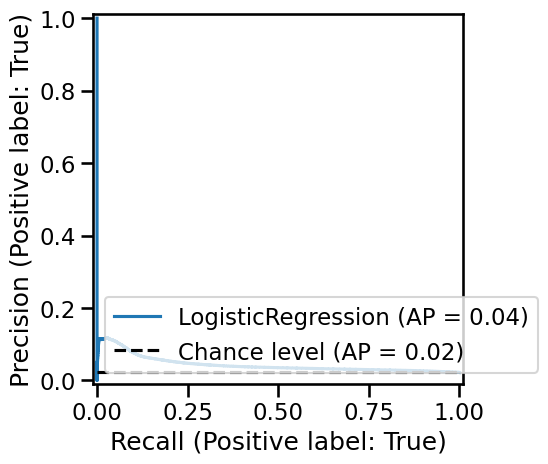

precision:  0.02194688832228094 
recall:  1.0 
random precision: 0.021952697451005733


 95%|█████████▍| 94/99 [00:04<00:00, 31.13it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:04<00:00, 21.41it/s]


Area Under Precision-Recall Curve (AUPRC):  0.046943676532538225
EPR: 4.326538348561062


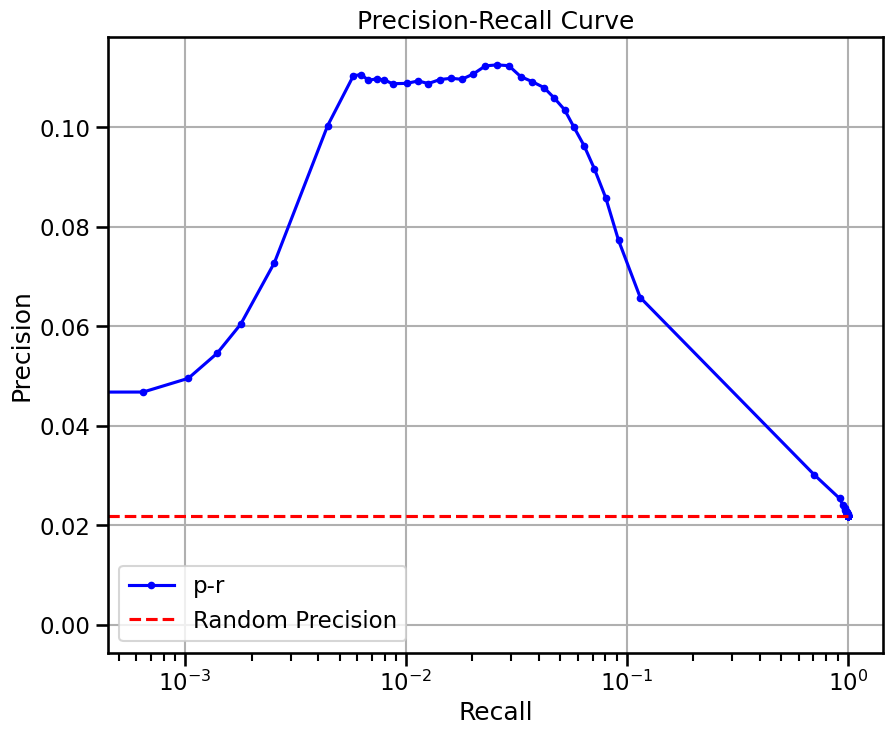

{'precision': 0.02194688832228094,
 'recall': 1.0,
 'rand_precision': 0.021952697451005733,
 'auprc': 0.046943676532538225,
 'EPR': 4.326538348561062}

In [8]:
metrics['scprint_self_perturb_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 8555


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 14341369, sparsity: 1.0


... storing 'organism_ontology_term_id' as categorical
... storing 'symbol' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'description' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.02194688832228094 
recall:  1.0 
random precision: 0.021952697451005733


 97%|█████████▋| 96/99 [00:04<00:00, 21.83it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:693: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:04<00:00, 22.52it/s]


Area Under Precision-Recall Curve (AUPRC):  0.031131338909927447
EPR: 2.7013433639995794


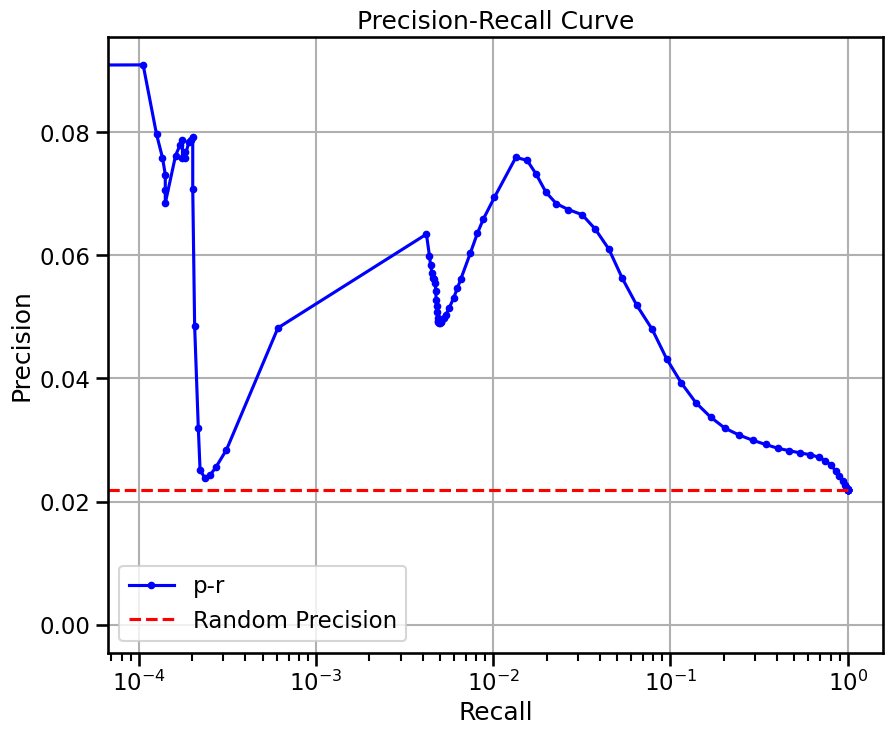

{'precision': 0.02194688832228094,
 'recall': 1.0,
 'rand_precision': 0.021952697451005733,
 'auprc': 0.031131338909927447,
 'epr': 2.7013433639995794}

In [12]:
grn_inferer = GRNfer(model, nadata[nadata.X.sum(1) > 500],
                     how="random_expr",
                     preprocess="softmax",
                     head_agg='mean',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     num_genes=3000,
                     max_cells=NUM_CELLS,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
metrics["scprint_full_perturb"] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

In [ ]:
metrics